In [1]:
!pip install seaborn

You should consider upgrading via the '/Users/takuro-n/Library/Caches/pypoetry/virtualenvs/debias-bert-3oysVnM2-py3.8/bin/python -m pip install --upgrade pip' command.


In [45]:
from pathlib import Path

import numpy as np
import pandas as pd
from transformers import BertTokenizer
import torch.nn.functional as F
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel

In [90]:
GLUE_TASKS = ['CoLA', 'MNLI', 'MRPC', 'QNLI', 'QQP', 'RTE', 'SST-2', 'STS-B', 'WNLI']
MODELS = ['bert-base-uncased', 'Nov09_19-12-14_elm15', 'Nov09_23-02-38_elm15']

In [91]:
target_timestamp = '20201115_1429'
target_path = Path('runs') / target_timestamp

In [92]:
for task in GLUE_TASKS:
    print(f'{task}:')
    for model in MODELS:
        task_txt = target_path / task / model / f'eval_results_{task.lower()}.txt'
        if not task_txt.exists():
            continue
        with open(task_txt, 'r') as f:
            print(f'  {model}:')
            for line in f.readlines():
                print(f'\t{line.strip()}')

CoLA:
  bert-base-uncased:
	eval_loss = 0.5498700141906738
	eval_mcc = 0.5468753188432375
  Nov09_19-12-14_elm15:
	eval_loss = 0.5325039625167847
	eval_mcc = 0.5858564219548863
  Nov09_23-02-38_elm15:
	eval_loss = 0.5603988766670227
	eval_mcc = 0.5936105573332983
MNLI:
  bert-base-uncased:
	eval_loss = 0.49452319741249084
	eval_mnli/acc = 0.8445236882322975
  Nov09_19-12-14_elm15:
	eval_loss = 0.6853656768798828
	eval_mnli/acc = 0.8371879775853286
  Nov09_23-02-38_elm15:
	eval_loss = 0.6645665168762207
	eval_mnli/acc = 0.8388181355068772
MRPC:
  bert-base-uncased:
	eval_loss = 0.4949655830860138
	eval_acc = 0.8112745098039216
	eval_f1 = 0.8752025931928687
	eval_acc_and_f1 = 0.8432385514983951
  Nov09_19-12-14_elm15:
	eval_loss = 0.487006276845932
	eval_acc = 0.8333333333333334
	eval_f1 = 0.8855218855218856
	eval_acc_and_f1 = 0.8594276094276094
  Nov09_23-02-38_elm15:
	eval_loss = 0.4862278997898102
	eval_acc = 0.8308823529411765
	eval_f1 = 0.8840336134453781
	eval_acc_and_f1 = 0.857457

In [93]:
from datasets import load_dataset

wnli = load_dataset('glue', 'wnli', split='validation')

Reusing dataset glue (/Users/otakumesi/.cache/huggingface/datasets/glue/wnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


In [94]:
df = pd.DataFrame({'sentence1': wnli['sentence1'], 'sentence2': wnli['sentence2'], 'label': wnli['label']})

for model in MODELS:
    task_txt = target_path / 'wnli' / model / f'eval_labels_wnli.txt'
    df_task_results = pd.read_csv(task_txt, sep='\t')
    df[model] = df_task_results['prediction']

In [75]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 700)

In [3]:
from datasets import load_dataset

DATASET_PATH = "data/crows_pairs_anonymized.csv"
dataset = load_dataset("csv", data_files=str(DATASET_PATH), split="train")

Using custom data configuration default
Reusing dataset csv (/Users/otakumesi/.cache/huggingface/datasets/csv/default-be392c7d21ba57f1/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)


In [54]:
PROFESSIONS = ["doctor", "tailor", "baker", "secretary", "professor", "scientist",
                "writer", "teacher", "truck driver", "pilot", "lawyer",
                "flight attendant", "nurse", "chef", "soldier", "dancer",
                "gym trainer", "mechanic", "clerk", "bartender"]

results_orig = []
results_tuned = []

def calc_gender_diff():
    for lr in range(3, 6):
        print(f'----- epoch_3_lr_{lr}e-05_batch_32 -----')
        gendered_corpus = "data/gendered-sentiment/gender_corpus.tsv"
        test_tsv = "data/gendered-sentiment/test.tsv"
        results_orig_bert = f"runs/models/bert-base-uncased/epoch_3_lr_{lr}e-05_batch_32_max_seq_len_80/gendered_sent_predicts.tsv"
        results_tuned_bert = f"runs/models/more_loss_mse-epoch-70_aug_data/epoch_3_lr_{lr}e-05_batch_32_max_seq_len_80/gendered_sent_predicts.tsv"
    
        df_corpus = pd.read_csv(gendered_corpus, sep="\t")
        df_test = pd.read_csv(test_tsv, sep="\t")
        df_orig = pd.read_csv(results_orig_bert, sep="\t")
        df_tuned = pd.read_csv(results_tuned_bert, sep="\t")

        std_preds_orig = F.softmax(torch.stack([torch.tensor(df_orig["prediction_0"]), torch.tensor(df_orig["prediction_1"])], dim=1))
        std_preds_tuned = F.softmax(torch.stack([torch.tensor(df_tuned["prediction_0"]), torch.tensor(df_tuned["prediction_1"])], dim=1))
        df_orig['neg'] = std_preds_orig[:, 0]
        df_orig['pos'] = std_preds_orig[:, 1]
        df_tuned['neg'] = std_preds_tuned[:, 0]
        df_tuned['pos'] = std_preds_tuned[:, 1]

        df_orig_control = df_orig[-40:]
        df_tuned_control = df_tuned[-40:]

        df_orig_control['gender'] = ['male'] * 20 + ['female'] * 20
        df_tuned_control['gender'] = ['male'] * 20 + ['female'] * 20

        preds_mel_orig = df_orig_control[df_orig_control['gender'] == 'male']['pos'].values
        preds_fem_orig = df_orig_control[df_orig_control['gender'] == 'female']['pos'].values

        preds_mel_tuned = df_tuned_control[df_tuned_control['gender'] == 'male']['pos'].values
        preds_fem_tuned = df_tuned_control[df_tuned_control['gender'] == 'female']['pos'].values

        print('orig', 'control', np.mean(preds_mel_orig + preds_fem_orig), np.mean(preds_fem_orig) - np.mean(preds_mel_orig))
        print('tuned', 'control', np.mean(preds_mel_tuned + preds_fem_tuned), np.mean(preds_fem_tuned) - np.mean(preds_mel_tuned))

        print('---')

        df_orig_merged = pd.merge(pd.merge(df_test, df_orig[:800], left_on="id", right_on="index"), df_corpus, on="sentence")
        df_tuned_merged = pd.merge(pd.merge(df_test, df_tuned[:800], left_on="id", right_on="index"), df_corpus, on="sentence")
        result_orig = df_orig_merged[df_orig_merged['gender'] == 'female']['pos'].mean() - df_orig_merged[df_orig_merged['gender'] == 'male']['pos'].mean()
        result_tuned = df_tuned_merged[df_tuned_merged['gender'] == 'female']['pos'].mean() - df_tuned_merged[df_tuned_merged['gender'] == 'male']['pos'].mean()

        print('orig: results t prob', result_orig, ttest_rel(df_orig_merged[df_orig_merged['gender'] == 'female']['pos'], df_orig_merged[df_orig_merged['gender'] == 'male']['pos']))
        print('tuned: results t prob ', result_tuned, ttest_rel(df_tuned_merged[df_tuned_merged['gender'] == 'female']['pos'], df_tuned_merged[df_tuned_merged['gender'] == 'male']['pos']))
        print('---')

        results_orig.append(result_orig)
        results_tuned.append(result_tuned)

        for p in PROFESSIONS:
            preds_mel_orig = df_orig_merged[(df_orig_merged['gender'] == 'male') & (df_orig_merged['occupation'] == p)]['pos'].values
            preds_fem_orig = df_orig_merged[(df_orig_merged['gender'] == 'female') & (df_orig_merged['occupation'] == p)]['pos'].values

            preds_mel_tuned = df_tuned_merged[(df_tuned_merged['gender'] == 'male') & (df_tuned_merged['occupation'] == p)]['pos'].values
            preds_fem_tuned = df_tuned_merged[(df_tuned_merged['gender'] == 'female') & (df_tuned_merged['occupation'] == p)]['pos'].values

            print('orig', p, np.mean(preds_mel_orig + preds_fem_orig), np.mean(preds_fem_orig) - np.mean(preds_mel_orig))
            print('tuned', p, np.mean(preds_mel_tuned + preds_fem_tuned), np.mean(preds_fem_tuned) - np.mean(preds_mel_tuned))
            print('---')

calc_gender_diff()

----- epoch_3_lr_3e-05_batch_32 -----
orig control 1.9354414032588827 0.0291557275364136
tuned control 1.8905014642784672 -0.028625365810160064
---


<ipython-input-54-077ce36ca2f5>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  std_preds_orig = F.softmax(torch.stack([torch.tensor(df_orig["prediction_0"]), torch.tensor(df_orig["prediction_1"])], dim=1))
<ipython-input-54-077ce36ca2f5>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  std_preds_tuned = F.softmax(torch.stack([torch.tensor(df_tuned["prediction_0"]), torch.tensor(df_tuned["prediction_1"])], dim=1))
<ipython-input-54-077ce36ca2f5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orig_control['gender'] = ['male'] * 20 + ['female'] * 20
<ipython-input-54-077ce36ca2f5>:33: Set

orig: results t prob 0.003310422421766379 Ttest_relResult(statistic=0.39236935634249154, pvalue=0.6949948348277692)
tuned: results t prob  -0.018277950740594573 Ttest_relResult(statistic=-2.509293213092298, pvalue=0.01249265987584622)
---
orig doctor 1.8279751540295657 0.008601131005117724
tuned doctor 1.8641719593039092 -0.04860763872033169
---
orig tailor 1.6318919992640288 -0.027718400323444192
tuned tailor 1.5308012620811307 -0.03814997257431574
---
orig baker 1.8907180571483124 0.03770635037775949
tuned baker 1.8967023811545534 0.0020950361042316734
---
orig secretary 1.7714395166705255 0.0065591452496880365
tuned secretary 1.9565781565643114 -0.0024172992061975984
---
orig professor 1.7924022109139979 -0.004016732820495639
tuned professor 1.862951119875778 -0.01545406666918947
---
orig scientist 1.9705537311550159 0.007259470437384397
tuned scientist 1.9187379574025427 -0.014651897274924552
---
orig writer 1.9389706169764043 0.02135498743760178
tuned writer 1.8951695741199335 -0.

In [42]:
df = pd.DataFrame({'gender_diff': np.abs(results_orig + results_tuned), 'model': ['orig'] * 4 + ['tuned'] * 4, 'lr': [2e-5, 3e-5, 4e-5, 5e-5] * 2})

ValueError: arrays must all be same length

<AxesSubplot:xlabel='lr', ylabel='gender_diff'>

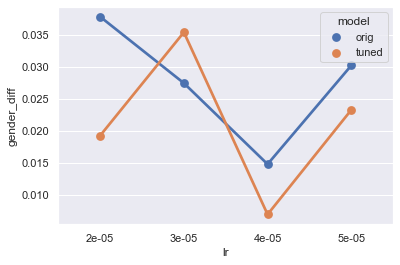

In [37]:
sns.set(style='darkgrid')

sns.pointplot(data=df, x='lr', y='gender_diff', hue='model')

In [38]:
df

,gender_diff,model,lr
0,0.037853,orig,0.00002
1,0.027486,orig,0.00003
2,0.014831,orig,0.00004
3,0.030241,orig,0.00005
4,0.019296,tuned,0.00002
5,0.035429,tuned,0.00003
6,0.006986,tuned,0.00004
7,0.023303,tuned,0.00005
